# 1- Import the needed library

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import string
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from skmultilearn.problem_transform import ClassifierChain
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
%matplotlib inline
from sklearn import tree
import matplotlib
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras import layers
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GEM001\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 2-Read the csv File and Drop null values

In [2]:
dfref =  pd.read_excel(r'C:\Users\GEM001\Downloads\rec.xlsx')

In [3]:
dfref.dropna(subset = ["FEATURE REQUEST"], inplace=True)
dfref = dfref.drop_duplicates(subset=['FEATURE REQUEST'])
print(dfref.shape)
dfref.describe()

(6881, 3)


,REFACTORINGS (LABELS),FEATURE REQUEST,SMELLS
count,6881,6881,6866
unique,572,6881,68
top,"Extract Method,",[DB optimization] revisit eagerLoadState at pl...,"Duplicated Code, Long Method, ,"
freq,1826,1,2985


# 3- Generic function to convert the dataset into binary form

In [4]:
def createArrayOfLabels(df):
    mlb = MultiLabelBinarizer()
    tempdf = pd.DataFrame(columns=['labels'])
    for i in df:
        temp = []
        try:
            i = i.replace(' ','')
            for j in i.split(','):
                if j != '':
                    temp.append(j.strip())
        except:
            pass
        tempdf = tempdf.append(pd.DataFrame({'labels': [temp]}))
        
    tempdf.apply(lambda x: tuple(x.values))
    mlb.fit(tempdf['labels'])
    tempdf = mlb.transform(tempdf['labels'])
    tempdf = pd.DataFrame(tempdf,columns =list(mlb.classes_) )
    return tempdf




# 4-Generic function use for Data pre-processing

In [5]:
def preprocess(x):
    try:
        stop_words = stopwords.words('english')
        lemmatizer = WordNetLemmatizer() 
        x = x.lower()
        x = x.translate(str.maketrans('', '', string.punctuation))
        x = x.split()
        x = [word for word in x if word not in stop_words]
        x = [lemmatizer.lemmatize(word) for word in x]
        x = str(x).replace(',',' ').replace("'","")[1:-1]
        return x
    except:
        print(f'There is an error in {x}')
        return 'empty'
    
    

# 5-Apply data binarization methods

In [6]:
smells = createArrayOfLabels(dfref['SMELLS'])

In [7]:
labels = createArrayOfLabels(dfref['REFACTORINGS (LABELS)'])


# 6- Concatenate dataframes (The binarization columns with FEATURE REQUEST column)

In [8]:
dfref = dfref.reset_index(drop=True)
tocsv = pd.concat([dfref, smells, labels], axis = 1)

# 7- This step for FEATURE REQUEST column and apply  preprocessing method

In [9]:
tocsv.dropna(subset = ["FEATURE REQUEST"], inplace=True)
tocsv = tocsv.drop(columns=['REFACTORINGS (LABELS)', 'SMELLS'])
tocsv['FEATURE REQUEST'] = tocsv['FEATURE REQUEST'].apply(preprocess)
tocsv.to_csv(r'C:refPreprocessed.csv')

In [10]:
tocsv = pd.read_csv(r'C:refPreprocessed.csv')
tocsv

,Unnamed: 0,FEATURE REQUEST,DuplicatedCode,LargeClass,LongMethod,ExtractInterface,ExtractMethod,ExtractSuperclass,InlineMethod,MoveAndRenameClass,MoveAttribute,MoveClass,MoveMethod,PullUpAttribute,PullUpMethod,PushDownAttribute,PushDownMethod,RenameClass,RenameMethod
0,0,add relmetadataprovider parameter standard ...,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,allowing sqloperator overridden validation ...,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,2,add support translate expession fromstring...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,3,extend simplify reducing expression would ...,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,4,add support timestampadd timestampdiff fun...,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6876,6876,optionally provide schema information attr...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
6877,6877,leave webapplicationexception default proce...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6878,6878,provide realm management enduser add wick...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6879,6879,allow scripted customizations core customi...,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1


# 8- Text Vectorization is the process of converting text (FEATURE REQUEST) into numerical representation

In [11]:
v = TfidfVectorizer(max_features=1000)
x = v.fit_transform(tocsv['FEATURE REQUEST'])

# 9 - Concatenate dataframes (The binarization columns with FEATURE REQUEST column after the vectorization )

In [12]:
tocsv = pd.concat([pd.DataFrame(x.toarray()), tocsv], axis = 1)
print(tocsv.shape)

(6881, 1019)


# 10- Split The dataset 0.25 test 0.75 train

In [13]:
columns = list(tocsv.columns)

X_train,X_test, y_train , y_test  = train_test_split(tocsv[columns[:-14]],tocsv[columns[-14:]], test_size=0.25,random_state=42)


X_train = X_train.drop(columns=['FEATURE REQUEST'])
X_test = X_test.drop(columns=['FEATURE REQUEST'])

# 11-  Make all labels as one group (categories)

In [14]:
categories = list(y_train.columns)
print(categories)
print(y_test.sum())

['ExtractInterface', 'ExtractMethod', 'ExtractSuperclass', 'InlineMethod', 'MoveAndRenameClass', 'MoveAttribute', 'MoveClass', 'MoveMethod', 'PullUpAttribute', 'PullUpMethod', 'PushDownAttribute', 'PushDownMethod', 'RenameClass', 'RenameMethod']
ExtractInterface       33
ExtractMethod         998
ExtractSuperclass      29
InlineMethod          155
MoveAndRenameClass     56
MoveAttribute         217
MoveClass             162
MoveMethod            318
PullUpAttribute        39
PullUpMethod           54
PushDownAttribute      29
PushDownMethod         26
RenameClass           169
RenameMethod          615
dtype: int64


# 12 -Bulid a tranning model using (OneVsRestClassifier) fot multilabel classification this strategy consists of fitting one classifier per class + calculating test accuracy for each class

In [73]:
clf = Pipeline([('clf', OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1))])
avgAccuracy = 0
avgRecall = 0
avgPercision = 0
avgf1_score = 0

for category in categories:
    print('**Processing {} comments...**'.format(category))
    
    # Training RandomForestClassifiern model on train data
    clf.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = clf.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    avgAccuracy+=accuracy_score(y_test[category], prediction)
    print('Test recall is {}'.format(recall_score(y_test[category], prediction)))
    avgRecall += recall_score(y_test[category], prediction)
    print('Test precision is {}'.format(precision_score(y_test[category], prediction)))
    avgPercision += precision_score(y_test[category], prediction)
    print('Test f1_score is {}'.format(f1_score(y_test[category], prediction)))
    avgf1_score += f1_score(y_test[category], prediction)
    print("\n")
    
    
print(f'avgAccuracy{avgAccuracy/len(categories)}\navgRecall{avgRecall/len(categories)}\navgPercision{avgPercision/len(categories)}\navgF1-score{avgf1_score/len(categories)}')

**Processing ExtractInterface comments...**
Test accuracy is 0.981118373275236
Test recall is 0.10344827586206896
Test precision is 1.0
Test f1_score is 0.1875


**Processing ExtractMethod comments...**
Test accuracy is 1.0
Test recall is 1.0
Test precision is 1.0
Test f1_score is 1.0


**Processing ExtractSuperclass comments...**
Test accuracy is 0.9912854030501089
Test recall is 0.45454545454545453
Test precision is 1.0
Test f1_score is 0.625


**Processing InlineMethod comments...**
Test accuracy is 0.9114015976761075
Test recall is 0.01652892561983471
Test precision is 0.4
Test f1_score is 0.031746031746031744


**Processing MoveAndRenameClass comments...**
Test accuracy is 0.9702251270878722
Test recall is 0.0
Test precision is 0.0
Test f1_score is 0.0


**Processing MoveAttribute comments...**


C:\Users\GEM001\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.8656499636891793
Test recall is 0.0
Test precision is 0.0
Test f1_score is 0.0


**Processing MoveClass comments...**
Test accuracy is 0.9084967320261438
Test recall is 0.09558823529411764
Test precision is 0.8125
Test f1_score is 0.17105263157894737


**Processing MoveMethod comments...**
Test accuracy is 0.8162672476397966
Test recall is 0.008064516129032258
Test precision is 0.2222222222222222
Test f1_score is 0.01556420233463035


**Processing PullUpAttribute comments...**
Test accuracy is 0.9789397240377633
Test recall is 0.0
Test precision is 0.0
Test f1_score is 0.0


**Processing PullUpMethod comments...**


C:\Users\GEM001\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9709513435003632
Test recall is 0.024390243902439025
Test precision is 1.0
Test f1_score is 0.047619047619047616


**Processing PushDownAttribute comments...**
Test accuracy is 0.9832970225127088
Test recall is 0.0
Test precision is 0.0
Test f1_score is 0.0


**Processing PushDownMethod comments...**


C:\Users\GEM001\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9847494553376906
Test recall is 0.0
Test precision is 0.0
Test f1_score is 0.0


**Processing RenameClass comments...**


C:\Users\GEM001\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy is 0.9012345679012346
Test recall is 0.014598540145985401
Test precision is 0.6666666666666666
Test f1_score is 0.02857142857142857


**Processing RenameMethod comments...**
Test accuracy is 0.6753812636165577
Test recall is 0.3181818181818182
Test precision is 0.5682656826568265
Test f1_score is 0.40794701986754967


avgAccuracy0.924214130096483
avgRecall0.14538185783433935
avgPercision0.47640389796755117
avgF1-score0.17964288297983108


# 13 - Bulid Hyperparmeter method to find the best parameters for the SVM model

In [23]:
kernel= ['rbf','poly']
gamma = [x*0.01 for x in range(1,100,5)]
c = [x*0.01 for x in range(1,100,5)]
print(len(c)*len(gamma))
best_f1 = 0
best_model = None
for k in kernel:
    for g in gamma:
        for cons in c:
            classifier = ClassifierChain(svm.SVC(kernel=k, random_state=1, gamma=g, C=cons))
            classifier.fit(X_train, y_train)
            predictions = classifier.predict(X_test)
            if f1_score(y_test,predictions,average='micro') >= best_f1:
                best_f1 = f1_score(y_test,predictions,average='micro')
                print(f'the parameter of best model is kernel = {k} gamma = {g} const = {cons} the f1_score is {best_f1}')
                best_model = classifier

400
the parameter of best model is kernel = rbf gamma = 0.01 const = 0.01 the f1_score is 0.43504795117698336
the parameter of best model is kernel = rbf gamma = 0.01 const = 0.06 the f1_score is 0.5164294954721863
the parameter of best model is kernel = rbf gamma = 0.01 const = 0.11 the f1_score is 0.5164294954721863
the parameter of best model is kernel = rbf gamma = 0.01 const = 0.16 the f1_score is 0.5164294954721863
the parameter of best model is kernel = rbf gamma = 0.01 const = 0.21 the f1_score is 0.5164294954721863
the parameter of best model is kernel = rbf gamma = 0.01 const = 0.26 the f1_score is 0.5164294954721863
the parameter of best model is kernel = rbf gamma = 0.01 const = 0.31 the f1_score is 0.5946660789067666
the parameter of best model is kernel = rbf gamma = 0.01 const = 0.96 the f1_score is 0.5966681280140289
the parameter of best model is kernel = rbf gamma = 0.06 const = 0.21 the f1_score is 0.6021834061135372
the parameter of best model is kernel = rbf gamma 

the parameter of best model is kernel = rbf gamma = 0.26 const = 0.86 the f1_score is 0.612050281751192
the parameter of best model is kernel = rbf gamma = 0.26 const = 0.91 the f1_score is 0.612050281751192
the parameter of best model is kernel = rbf gamma = 0.26 const = 0.96 the f1_score is 0.612050281751192
the parameter of best model is kernel = rbf gamma = 0.31 const = 0.36 the f1_score is 0.612050281751192
the parameter of best model is kernel = rbf gamma = 0.31 const = 0.41000000000000003 the f1_score is 0.612050281751192
the parameter of best model is kernel = rbf gamma = 0.31 const = 0.46 the f1_score is 0.612050281751192
the parameter of best model is kernel = rbf gamma = 0.31 const = 0.51 the f1_score is 0.612050281751192
the parameter of best model is kernel = rbf gamma = 0.31 const = 0.56 the f1_score is 0.612050281751192
the parameter of best model is kernel = rbf gamma = 0.31 const = 0.61 the f1_score is 0.612050281751192
the parameter of best model is kernel = rbf gamma

the parameter of best model is kernel = poly gamma = 0.16 const = 0.86 the f1_score is 0.6123510292524378
the parameter of best model is kernel = poly gamma = 0.21 const = 0.31 the f1_score is 0.6123510292524378
the parameter of best model is kernel = poly gamma = 0.21 const = 0.36 the f1_score is 0.6123510292524378
the parameter of best model is kernel = poly gamma = 0.26 const = 0.16 the f1_score is 0.6123510292524378
the parameter of best model is kernel = poly gamma = 0.26 const = 0.21 the f1_score is 0.6123510292524378
the parameter of best model is kernel = poly gamma = 0.31 const = 0.11 the f1_score is 0.6123510292524378
the parameter of best model is kernel = poly gamma = 0.36 const = 0.06 the f1_score is 0.6123510292524378
the parameter of best model is kernel = poly gamma = 0.66 const = 0.01 the f1_score is 0.6123510292524378
the parameter of best model is kernel = poly gamma = 0.71 const = 0.01 the f1_score is 0.6123510292524378


# 14 - The tranning model with support vector machine 

In [51]:
classifier = ClassifierChain(svm.SVC(kernel='rbf', gamma=0.06, C=0.21))
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print("Accuracy = ",accuracy_score(y_test,predictions))
print(classification_report(y_test,predictions))

Accuracy =  0.34043583535108957


# 15 - The tranning model with multinomial naive bayes 

In [ ]:
classifier = ClassifierChain(MultinomialNB())
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
print(classification_report(y_test,predictions))


# 16 - The tranning model with RandomForestClassifier gave the best result

In [115]:
classifier = ClassifierChain(RandomForestClassifier(class_weight='balanced'))
classifier.fit(X_train, y_train)
print(X_test.shape)
predictions = classifier.predict(X_test)
print("Accuracy = ",accuracy_score(y_test,predictions))
print(classification_report(y_test,predictions))


(1721, 1004)
Accuracy =  0.4927367809413132
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        33
           1       1.00      1.00      1.00       998
           2       1.00      0.17      0.29        29
           3       0.44      0.03      0.05       155
           4       0.00      0.00      0.00        56
           5       0.50      0.00      0.01       217
           6       0.79      0.14      0.24       162
           7       0.50      0.00      0.01       318
           8       0.00      0.00      0.00        39
           9       0.67      0.07      0.13        54
          10       0.00      0.00      0.00        29
          11       0.00      0.00      0.00        26
          12       0.26      0.03      0.05       169
          13       0.55      0.55      0.55       615

   micro avg       0.82      0.48      0.60      2900
   macro avg       0.48      0.15      0.17      2900
weighted avg       0.67      0.48   

C:\Users\GEM001\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GEM001\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 17 - Generic method to Build the confusion_matrix with the Heatmap  

[[   1    0]
 [  32 1688]]


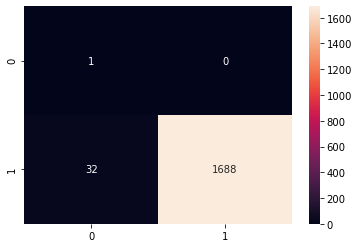

[[998   0]
 [  0 723]]


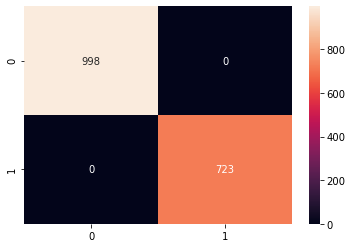

[[   5    0]
 [  24 1692]]


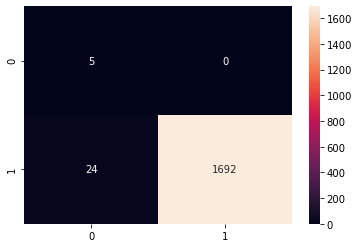

[[   4    5]
 [ 151 1561]]


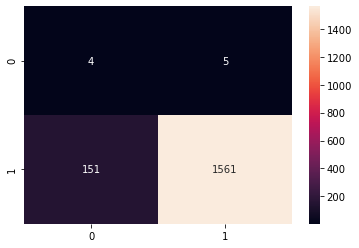

[[   0    0]
 [  56 1665]]


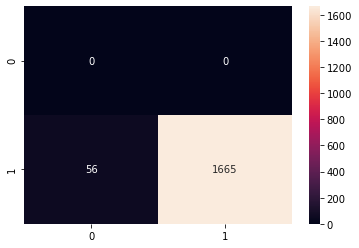

[[   1    1]
 [ 216 1503]]


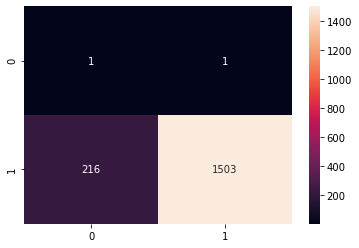

[[  23    6]
 [ 139 1553]]


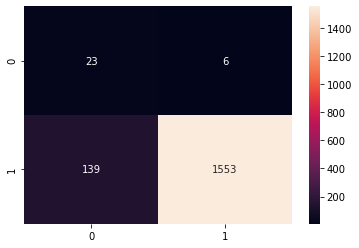

[[   1    1]
 [ 317 1402]]


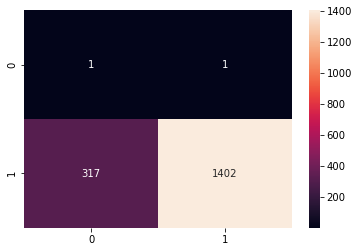

[[   0    0]
 [  39 1682]]


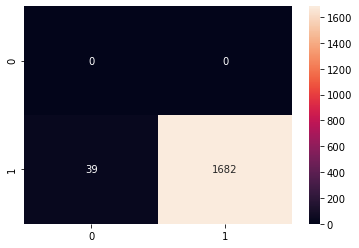

[[   4    2]
 [  50 1665]]


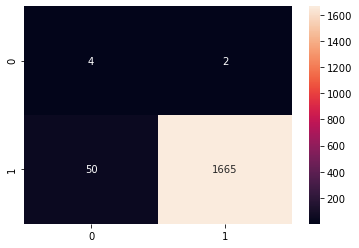

[[   0    0]
 [  29 1692]]


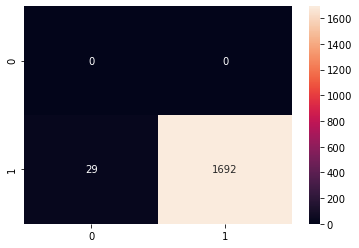

[[   0    0]
 [  26 1695]]


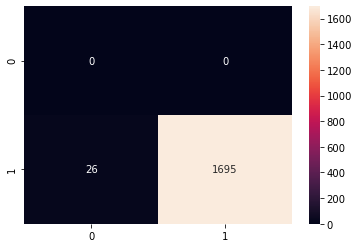

[[   5   14]
 [ 164 1538]]


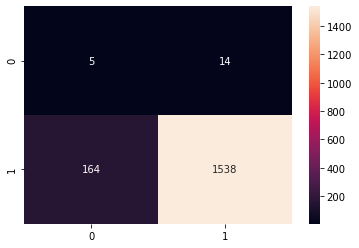

[[340 274]
 [275 832]]


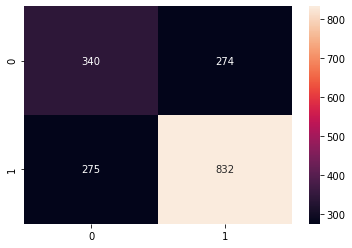

In [120]:
y_test.sum(axis = 1).sum()
from sklearn.metrics import confusion_matrix

pred  = np.array(predictions.toarray())


dfpred = pd.DataFrame(pred, columns = categories)

import seaborn as sns

for x in categories:
    print(confusion_matrix( dfpred[x],y_test[x],labels = [1,0]))
    sns.heatmap(confusion_matrix(dfpred[x],y_test[x] ,labels = [1,0]), annot=True, fmt='g')
    plt.show()


# 18- This method for oversampling technique  (Multilabel Synthetic Minority Over-sampling)

In [15]:
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors



def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe

    args
    df: pandas.DataFrame, target label df whose tail label has to identified

    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df):
    """
    give the index of all tail_label rows
    args
    df: pandas.DataFrame, target label df from which index for tail label has to identified

    return
    index: list, a list containing index number of all the tail label
    """
    tail_labels = get_tail_label(df)
    index = set()
    for tail_label in tail_labels:
        sub_index = set(df[df[tail_label]==1].index)
        index = index.union(sub_index)
    return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels

    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe

    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance

    args
    X: np.array, array whose nearest neighbor has to find

    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm

    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample

    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target


# 19 - split the dataset after the over sample technique

In [16]:
    X_sub, y_sub = get_minority_instace(X_train, y_train)   #Getting minority instance of that datframe
    X_res,y_res =MLSMOTE(X_sub, y_sub, 1000)     #Applying MLSMOTE to augment the dataframe
    print(X_sub,y_sub)
    print(X_res,y_res)
    print(y_res.sum(),y_train.sum())

       0    1    2         3    4    5    6         7        8         9  ...  \
0    0.0  0.0  0.0  0.057459  0.0  0.0  0.0  0.000000  0.00000  0.000000  ...   
1    0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.14353  0.000000  ...   
2    0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.00000  0.000000  ...   
3    0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.00000  0.000000  ...   
4    0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.00000  0.000000  ...   
..   ...  ...  ...       ...  ...  ...  ...       ...      ...       ...  ...   
625  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.00000  0.000000  ...   
626  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.00000  0.000000  ...   
627  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.00000  0.000000  ...   
628  0.0  0.0  0.0  0.040865  0.0  0.0  0.0  0.014697  0.00000  0.020986  ...   
629  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.138824  0.00000  0.000000  ...   

          994  995      996

# 20-Train The dataset after the over sampling

In [17]:
classifier = ClassifierChain(RandomForestClassifier(class_weight='balanced'))
classifier.fit(X_res, y_res)

predictions = classifier.predict(X_test)
print(classification_report(y_test,predictions))


              precision    recall  f1-score   support

           0       1.00      0.27      0.43        33
           1       1.00      0.99      1.00       998
           2       0.73      0.76      0.75        29
           3       0.00      0.00      0.00       155
           4       0.06      0.38      0.11        56
           5       0.10      0.02      0.04       217
           6       0.12      0.01      0.01       162
           7       0.22      0.04      0.06       318
           8       0.03      0.18      0.05        39
           9       0.05      0.59      0.08        54
          10       0.22      0.07      0.11        29
          11       0.22      0.08      0.11        26
          12       0.56      0.03      0.06       169
          13       0.32      0.16      0.21       615

   micro avg       0.44      0.42      0.43      2900
   macro avg       0.33      0.26      0.22      2900
weighted avg       0.51      0.42      0.42      2900
 samples avg       0.37   

C:\Users\GEM001\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GEM001\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
